# Use experiment 3 method used in experiment 1 over here

In [1]:
import os, sys, time
from math import floor
import pandas as pd
import seaborn as sns
import cv2
import numpy as np

from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

import tensorflow as tf
# # import tensorflow.compat.v1 as tf
# from tensorflow import keras
# from tensorflow.keras.layers import Lambda
# from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from collections import OrderedDict
# from tensorflow.python.ops import math_ops
# import tensorflow.keras.backend as kb
from tensorflow_addons.utils.ensure_tf_install import _check_tf_version
_check_tf_version()
from tensorflow_addons import losses


# Custom Functions
from load_data import Files_Load, Boxes, test_split_norm_abnorm, norm_train_max_min
from custom_metrics import bb_intersection_over_union, bb_intersection_over_union_np
from coordinate_change import xywh_tlbr, tlbr_xywh
from pedsort import pedsort
from load_data_binary_class import return_indices, binary_data_split, same_ratio_split_train_val
from load_data_binary_class import one_weight_ratio_train
from TP_TN_FP_FN import seperate_misclassifed_examples, sort_TP_TN_FP_FN_by_vid_n_frame
from plot_all_videos import cycle_through_videos

# Kmeans
from sklearn.cluster import KMeans

# Need to figue out why this is not working
# from persistence1d import RunPersistence


# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import roc_curve, precision_recall_curve
# from sklearn.metrics import plot_confusion_matrix

# GPU Check
### All I'm doing here is limiting memory growth. Could probably delete this now that I can use numerous gpus

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs



# Load Data
### Constants to change: Frames, Normization factor

In [12]:
FRAMES =20
BUFFER_SIZE = 100000
BATCH_SIZE = 32
TEST_SIZE = 0.3

In [13]:
train_file = '/mnt/roahm/users/akanu/dataset/Anomaly/ShangaiuTech/Txt_Data/Train_Box/'
test_file =  '/mnt/roahm/users/akanu/dataset/Anomaly/ShangaiuTech/Txt_Data/Test_Box/'

loc_files_train, loc_files_test, box_train_txt, box_test_txt = Files_Load(train_file, test_file)

# Don't forget to change to xywh 
traindict = Boxes(loc_files_train, box_train_txt, FRAMES, pad ='pre', to_xywh=True)
testdict = Boxes(loc_files_test, box_test_txt, FRAMES, pad ='pre', to_xywh = True)
abnormal_dict, normal_dict = test_split_norm_abnorm(testdict) #splits by which predicted frames are normal or not

# Normilize data
max1 = traindict['x_ppl_box'].max()
min1 = traindict['x_ppl_box'].min()
xx,yy = norm_train_max_min(data_dict = traindict, max1=max1,min1=min1)
# xx_norm,yy_norm = norm_train_max_min(data_dict = normal_dict, max1=max1,min1=min1)
# xx_abnorm,yy_abnorm = norm_train_max_min(data_dict = abnormal_dict, max1=max1,min1=min1)



In [14]:
xx_train, xx_val,yy_train,yy_val = train_test_split(xx,yy, test_size = TEST_SIZE)
train_univariate = tf.data.Dataset.from_tensor_slices((xx_train,yy_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_univariate = tf.data.Dataset.from_tensor_slices((xx_val,yy_val))
val_univariate = val_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [15]:
traindict['x_ppl_box'].shape

(1002287, 20, 4)

# Load or Train Model


### Naming convention of saved models

model: lstm

type: xywh, tlbr

dataset: ped1,ped2,st, avenue

seq: size of sequence, 20, 5 etc int of sequence

model_type_dataset_seq.h5

example: lstm_xywh_ped1_20.h5


## Need to fix that path that I need to inset the path to load model Right Now to load model I would need to insert the model path. Could I put it in PYTHONPATH or is there a better way to do it.. Actually Probably best to move file into PYTHONPATH location. That makes more sense.

1) I moved binary classifaction and lstm model py files into custom functions

2) I just changed name from lstm_xywh_avenue_20 to lstm_xywh_20 because I can still use same archieture for a different dataset
    
    a) I want to remove 20 possibly and make generic to other                timelengths
    

In [16]:
nc=['lstm', 'xywh', 'st', FRAMES] # This corresponds to standard to save models 

In [17]:
from lstm_models import lstm_xywh_20 
# I should change this name to be more genric 

In [18]:
# This can be a static play because its location is "fixed"
model_loc = '/mnt/roahm/users/akanu/projects/anomalous_pred/results_all_datasets/shtech/saved_models/exp3'

In [19]:
model = lstm_xywh_20(train_univariate, val_univariate, model_loc, nc)

Epoch 1/300
21925/21925 [==============================] - 154s 7ms/step - loss: 0.0215 - val_loss: 0.0013
Epoch 2/300
21925/21925 [==============================] - 163s 7ms/step - loss: 9.2395e-04 - val_loss: 7.1676e-04
Epoch 3/300
21925/21925 [==============================] - 155s 7ms/step - loss: 5.9143e-04 - val_loss: 4.6799e-04
Epoch 4/300
21925/21925 [==============================] - 153s 7ms/step - loss: 3.9218e-04 - val_loss: 3.2925e-04
Epoch 5/300
21925/21925 [==============================] - 153s 7ms/step - loss: 2.8231e-04 - val_loss: 2.4996e-04
Epoch 6/300
21925/21925 [==============================] - 153s 7ms/step - loss: 2.3232e-04 - val_loss: 2.2039e-04
Epoch 7/300
21925/21925 [==============================] - 154s 7ms/step - loss: 2.0969e-04 - val_loss: 2.0178e-04
Epoch 8/300
21925/21925 [==============================] - 153s 7ms/step - loss: 1.9399e-04 - val_loss: 1.8853e-04
Epoch 9/300
21925/21925 [==============================] - 154s 7ms/step - loss: 1.8262e

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(model.history['loss'], '-', color='black', label='loss')
ax.plot(model.history['val_loss'], '-', color='red', label='Validation loss')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')


#### Think I probably need to go back and play with the weights. This model is appears to converge quickly. How does converage compare to when I looked at Avenue dataset? Avenue Dataset appears to converge quickly for bounding box predictions . Also note that the way I defined the models in lstm_models the history is returned which allows me to make plots etc. However to acess the model and do predictions I need to load the model that was saved during the training process.

# Loading Model

In [51]:
model_loc

'/mnt/roahm/users/akanu/projects/anomalous_pred/results_all_datasets/shtech/saved_models/exp3'

In [52]:
loaded_model = os.path.join(model_loc,
                            '{}_{}_{}_{}.h5'.format(nc[0], nc[1],nc[2], nc[3]))
lstm_20 = tf.keras.models.load_model(loaded_model,  
                                   custom_objects = {'loss':'mse'} , 
                                   compile=True)


# Weighted Loss

In [26]:
WEIGHT_RATIO =1
INITIAL_BIAS = np.log([WEIGHT_RATIO])

## 1) Go back through why didn't use weighted_cross_entropy_loss builtin

In [27]:
# SHOULD CHANGE HOW INPUTTED WEIGHT_RATIO INTO LOSS
# FUNCTION TO MAKE MORE MODULAR
def loss(y_true, y_pred):
    when_y_1 = y_true*tf.keras.backend.log(y_pred)*(1/WEIGHT_RATIO)
    neg_y_pred = Lambda(lambda x: -x)(y_pred)
    when_y_0 = ( 1+Lambda(lambda x: -x)(y_true))*tf.keras.backend.log(1+neg_y_pred )
    
    weighted_cross_entr = Lambda(lambda x: -x)(when_y_0+when_y_1)
    return weighted_cross_entr

# Seed information and other constants

In [70]:
seed_exp_1 = [23,24,35,81]
ABNORMAL_SPLIT =0.5
VAL_RATIO = 0.3

In [71]:
indices_exp_1 = return_indices(testdict['abnormal'], 
                               abnormal_split = ABNORMAL_SPLIT, 
                               seed=seed_exp_1[0])


In [72]:
x_exp_1,y_exp_1 = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )

this function takes normed data and returns data with IOU and return_indices. Indices can be used to track back to location in unshuffled testdict.So that visulzations of what can be given as to what happened.

1) GO BACK AND CHANGE THE BINARY_DATA_SPLIT FUNCTION TO MAKE CLEARER

In [73]:
train_full_x_exp_1,train_full_y_exp_1, test_x_exp_1, test_y_exp_1 = binary_data_split(x_exp_1,
                                                                          y_exp_1,
                                                                          lstm_20,
                                                                          indices_exp_1)

In [74]:
print('Comparing shape length of train_full_x and test_x \n' +
     'train_full_x: {}, test_x:{}'.format(train_full_x_exp_1.shape,
                                         test_x_exp_1.shape))

Comparing shape length of train_full_x and test_x 
train_full_x: (2, 152147), test_x:(2, 14780)


In [75]:
# Change name from one_weight_ratio_split to equal_binary_train_split

In [76]:
train_x_even_split_exp_1, train_y_even_split_exp_1 = one_weight_ratio_train(
                                        train_full_x_exp_1,
                                        train_full_y_exp_1)

In [77]:
val_x_exp_1, val_y_exp_1, train_x_exp_1, train_y_exp_1 = same_ratio_split_train_val(
    train_x_even_split_exp_1,train_y_even_split_exp_1, val_ratio = VAL_RATIO)
# weight_ratio = len(indices_exp_1[0])/len(indices_exp_1[1])

In [78]:
# Note that I need to index into correct column as one is IOU
# and last column is index values to map back into datadicg
train_bm_exp_1 = tf.data.Dataset.from_tensor_slices((train_x_exp_1[0,:],train_y_exp_1))
train_bm_exp_1 = train_bm_exp_1.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_bm_exp_1 = tf.data.Dataset.from_tensor_slices((val_x_exp_1[0,:],val_y_exp_1))
val_bm_exp_1 = val_bm_exp_1.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [94]:
from binary_classification import Dense_5_Drop_2

In [90]:
nc_bin_exp_1 = ['seed{}_Dense_5_Drop_5_exp_1', 'xywh','avenue', FRAMES, 0.500]

In [91]:
nc_bin_exp_1[0] = nc_bin_exp_1[0].format(seed_exp_1[0])

In [92]:
nc_bin_exp_1

['seed23_Dense_5_Drop_5_exp_1', 'xywh', 'avenue', 20, 0.5]

In [95]:
model_loc_exp = os.path.join(model_loc, 'Experiment_3')
model_loc_exp

'/mnt/roahm/users/akanu/projects/anomalous_pred/results_all_datasets/shtech/saved_models/exp3/Experiment_3'

# Train Data Experiment 1 Data

In [97]:
bm_history_exp_1,bm_model_exp_1 = Dense_5_Drop_2(train_bm_exp_1,
                              val_bm_exp_1,
                              os.path.join(model_loc_exp, 
                                            'using_exp_1_method'),
                              nc_bin_exp_1,
                              loss,
                              INITIAL_BIAS,
                              1000,
                              save_model=False,
                              patience = 50
                             )


Epoch 1/1000
324/324 [==============================] - 1s 2ms/step - loss: 0.6938 - accuracy: 0.4931 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/1000
324/324 [==============================] - 1s 2ms/step - loss: 0.6938 - accuracy: 0.4914 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 3/1000
324/324 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5090 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 4/1000
324/324 [==============================] - 1s 2ms/step - loss: 0.6939 - accuracy: 0.4924 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 5/1000
324/324 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5033 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 6/1000
324/324 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5015 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 7/1000
324/324 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5082 - val_loss: 0.6923 - val_accuracy:

324/324 [==============================] - 1s 2ms/step - loss: 0.6743 - accuracy: 0.6046 - val_loss: 0.6701 - val_accuracy: 0.6500
Epoch 114/1000
324/324 [==============================] - 1s 2ms/step - loss: 0.6746 - accuracy: 0.6053 - val_loss: 0.6697 - val_accuracy: 0.6473
Epoch 115/1000
324/324 [==============================] - 1s 2ms/step - loss: 0.6731 - accuracy: 0.6052 - val_loss: 0.6692 - val_accuracy: 0.6475
Epoch 116/1000
324/324 [==============================] - 1s 2ms/step - loss: 0.6731 - accuracy: 0.6043 - val_loss: 0.6687 - val_accuracy: 0.6498
Epoch 117/1000
324/324 [==============================] - 0s 2ms/step - loss: 0.6726 - accuracy: 0.6048 - val_loss: 0.6682 - val_accuracy: 0.6477
Epoch 118/1000
324/324 [==============================] - 1s 2ms/step - loss: 0.6737 - accuracy: 0.6063 - val_loss: 0.6678 - val_accuracy: 0.6464
Epoch 119/1000
324/324 [==============================] - 0s 2ms/step - loss: 0.6719 - accuracy: 0.6096 - val_loss: 0.6674 - val_accuracy: 

324/324 [==============================] - 1s 2ms/step - loss: 0.6454 - accuracy: 0.6311 - val_loss: 0.6334 - val_accuracy: 0.6531
Epoch 226/1000
324/324 [==============================] - 1s 2ms/step - loss: 0.6444 - accuracy: 0.6327 - val_loss: 0.6333 - val_accuracy: 0.6547
Epoch 227/1000
324/324 [==============================] - 0s 2ms/step - loss: 0.6454 - accuracy: 0.6300 - val_loss: 0.6333 - val_accuracy: 0.6572
Epoch 228/1000
324/324 [==============================] - 0s 2ms/step - loss: 0.6464 - accuracy: 0.6307 - val_loss: 0.6333 - val_accuracy: 0.6583
Epoch 229/1000
324/324 [==============================] - 0s 2ms/step - loss: 0.6460 - accuracy: 0.6324 - val_loss: 0.6332 - val_accuracy: 0.6540
Epoch 230/1000
324/324 [==============================] - 0s 2ms/step - loss: 0.6447 - accuracy: 0.6378 - val_loss: 0.6331 - val_accuracy: 0.6574
Epoch 231/1000
324/324 [==============================] - 0s 2ms/step - loss: 0.6449 - accuracy: 0.6382 - val_loss: 0.6331 - val_accuracy: 

324/324 [==============================] - 1s 2ms/step - loss: 0.6408 - accuracy: 0.6386 - val_loss: 0.6303 - val_accuracy: 0.6601
Epoch 338/1000
324/324 [==============================] - 0s 2ms/step - loss: 0.6391 - accuracy: 0.6406 - val_loss: 0.6302 - val_accuracy: 0.6599
Epoch 339/1000
324/324 [==============================] - 1s 2ms/step - loss: 0.6402 - accuracy: 0.6402 - val_loss: 0.6304 - val_accuracy: 0.6570
Epoch 340/1000
324/324 [==============================] - 1s 2ms/step - loss: 0.6412 - accuracy: 0.6399 - val_loss: 0.6303 - val_accuracy: 0.6604
Epoch 341/1000
324/324 [==============================] - 1s 2ms/step - loss: 0.6418 - accuracy: 0.6393 - val_loss: 0.6302 - val_accuracy: 0.6585
Epoch 342/1000
324/324 [==============================] - 0s 2ms/step - loss: 0.6406 - accuracy: 0.6400 - val_loss: 0.6303 - val_accuracy: 0.6601
Epoch 343/1000
324/324 [==============================] - 1s 2ms/step - loss: 0.6425 - accuracy: 0.6398 - val_loss: 0.6303 - val_accuracy: 

Note difference in models for lstm model I only returned history file but for binary classifer I retuned both the histrory file and model that allows for prediction. The advatange of each one is t

Text(0, 0.5, 'Loss')

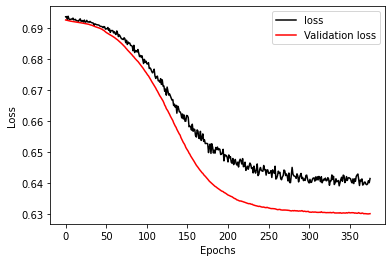

In [100]:
fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.plot(bm_history_exp_1.history['loss'], '-', color='black',label='loss')
ax.plot(bm_history_exp_1.history['val_loss'],'-',color='red' ,label ='Validation loss')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.title('Zero Initial Bias Last Layer')

Text(0, 0.5, 'Accuracy')

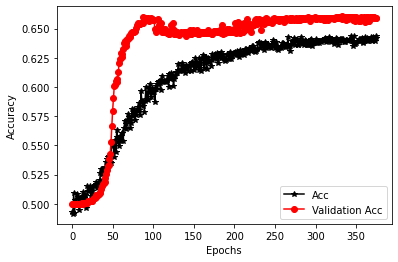

In [101]:
fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.plot(bm_history_exp_1.history['accuracy'], '-*', color='black',label='Acc')
ax.plot(bm_history_exp_1.history['val_accuracy'],'-o', color='red', label ='Validation Acc')
ax.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.title('Zero Initial Bias Last Layer')

Text(0.5, 0, 'Count')

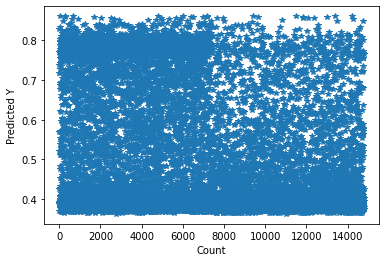

In [103]:
fig,ax = plt.subplots(1,1)
ax.plot(bm_model_exp_1.predict(test_x_exp_1[0,:]), '*')
# plt.title('Zero Initial Bias Last Layer')
plt.ylabel('Predicted Y')
plt.xlabel('Count')

# Add ROC Curve